## Figures 4-5

The density plots show the correlation between the chromatin accessibility measured by ATAC-seq and the acetylation and methylation profiles which are related to Acetyl-CoA and SAM fluxes.

In [1]:
import pandas as pd
import numpy as np
import cobra
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy import stats
from scipy.interpolate import interp1d
from scipy.stats import mannwhitneyu 
import time

In [2]:
#upload files
#RNA-seq from Kuang et al. (2014) 
fpkm=pd.read_csv("/home/bguzman/jupyter/UI/YMC/data/RNA_new/KuangRNAseq_15.csv",index_col=0)
#ATAC-seq from Gowans et al. (2018)
atac=pd.read_csv("/home/bguzman/jupyter/UI/YMC/data/GSE101290_normalized_atac_counts.csv",index_col=0)
#stages YMC from Kuang et al. (2014)
OX= pd.read_csv("/home/bguzman/jupyter/UI/YMC/data/kuangOX.txt", sep="\t")
RB= pd.read_csv("/home/bguzman/jupyter/UI/YMC/data/kuangRB.txt", sep="\t")
RC= pd.read_csv("/home/bguzman/jupyter/UI/YMC/data/kuangRC.txt", sep="\t")
#Fluxes of ACOA and SAM from Pheflux2.0
ACOA_all=pd.read_csv("/home/bguzman/jupyter/UI/YMC/analysis/vectores_febrero2023/vectorAC_15_allflux.csv",index_col=0)
SAM_all=pd.read_csv("/home/bguzman/jupyter/UI/YMC/analysis/vectores_febrero2023/vectorME_15_allflux.csv",index_col=0)
#ChIP-seq from Kuang et al. (2014)
H3K9ac=pd.read_csv("/home/bguzman/jupyter/UI/YMC/analysis/dfi_T_15_ac.csv", index_col=0)
H3K4me3=pd.read_csv("/home/bguzman/jupyter/UI/YMC/analysis/dfi_T_15_me.csv", index_col=0)



In [3]:
#Get average between the different elements of replicates 1, 2; 3. 4; 5, 6.
genes=atac.index
T1=list((atac.iloc[: , 1].values+atac.iloc[: , 2].values)/2)
T2=list((atac.iloc[: , 3].values+atac.iloc[: , 4].values)/2)
T3=list((atac.iloc[: , 5].values+atac.iloc[: , 6].values)/2)
T4=list((atac.iloc[: , 7].values+atac.iloc[: , 8].values)/2)
T5=list((atac.iloc[: , 9].values+atac.iloc[: , 10].values)/2)
T6=list((atac.iloc[: , 11].values+atac.iloc[: , 12].values)/2)

In [4]:
#Make df from the lists made with the averages of the replicates
import pandas as pd
import numpy as np
lst1 = genes
lst2 = T2 # RC
lst3= T3  # OX
lst4= T4  # OX
lst5= T5  # RB
lst6= T6  # RB
lst7= T1  # RC
atac_prom = pd.DataFrame(list(zip(lst1,lst2,lst3,lst4,lst5,lst6,lst7)), columns = ['Genes','T1','T2','T3','T4','T5','T6'])
#set the gene.id column as index to make the heatmap
df_atac = atac_prom.set_index(['Genes'])


In [5]:
#Define lists with genes by stage
lista_RC=list(RC.iloc[0:-2,0])
lista_OX=list(OX.iloc[0:-2,0])
lista_RB=list(RB.iloc[0:-2,0])

In [6]:
#Stage lists in atac-seq
list_1=lista_RC
list_2=atac.index
from collections import Counter
cnt1 = Counter(list_1)
cnt2 = Counter(list_2)
lista_RC_ss= [key for key, counts in cnt2.items() if cnt1[key] == counts]

list_3=lista_OX
list_4=atac.index
from collections import Counter
cnt3 = Counter(list_3)
cnt4 = Counter(list_4)
lista_OX_ss= [key for key, counts in cnt4.items() if cnt3[key] == counts]

list_5=lista_RB
list_6=atac.index
from collections import Counter
cnt5 = Counter(list_5)
cnt6 = Counter(list_6)
lista_RB_ss= [key for key, counts in cnt6.items() if cnt5[key] == counts]

In [7]:
lista_RC_ss=[]
for gene in lista_RC:
    if gene in atac.index:
          lista_RC_ss.append(gene)

lista_OX_ss=[]
for gene in lista_OX:
    if gene in atac.index:
          lista_OX_ss.append(gene)
            
lista_RB_ss=[]
for gene in lista_RB:
    if gene in atac.index:
          lista_RB_ss.append(gene)

In [8]:
from scipy import stats
   
#Calculation of the correlation between the precursor and the epigenetic mark
def ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa):
    # subsets the dataframe
    df = marcaEpigenetica.loc[genesEtapa]
    # Computes the correlation
    corr=[]
    for i in range(len(df)):
        a = np.array(df.iloc[i,:])
        b = np.array(perfilPrecursor)[0]
        corr.append(stats.pearsonr(a,b)[0])
    #order correlation from highest to lowest
    df_corr=pd.DataFrame(corr,index =df.index,columns = ['correlation'])
    corr_sort = df_corr.sort_values('correlation',ascending=False)

    return(corr_sort)


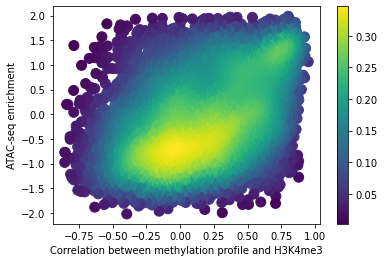

In [9]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = corrs
y = dfx["T1"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Correlation between methylation profile and H3K4me3")
plt.ylabel("ATAC-seq enrichment") 

cbar = fig.colorbar(scatter)
plt.savefig("corr_1me_all.svgz")

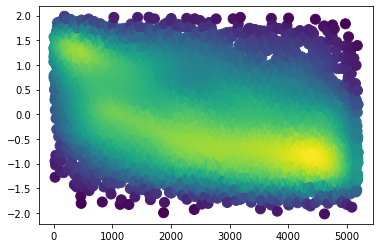

In [10]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = range(dfx["T1"].size)
y = dfx["T1"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
#plt.savefig("sp_1me_all.svg")



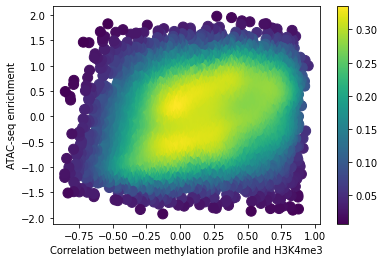

In [11]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = corrs
y = dfx["T2"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)


fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Correlation between methylation profile and H3K4me3")
plt.ylabel("ATAC-seq enrichment") 

cbar = fig.colorbar(scatter)

plt.savefig("corr_2me_all.svgz")

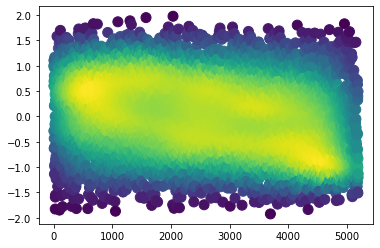

In [12]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = range(dfx["T2"].size)
y = dfx["T2"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
#plt.savefig("sp_2me_all.svg")

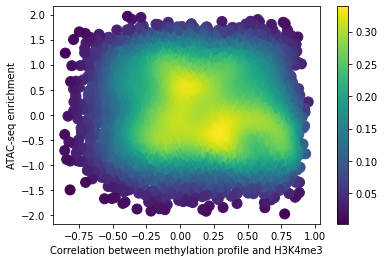

In [13]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = corrs
y = dfx["T3"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Fonts
#plt.rcParams['font.family'] = 'cmr10'  # o 'cmr12' o 'cmr17' para la fuente Computer Modern

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Correlation between methylation profile and H3K4me3")
plt.ylabel("ATAC-seq enrichment") 

cbar = fig.colorbar(scatter)

plt.savefig("corr_3me_all.svgz")

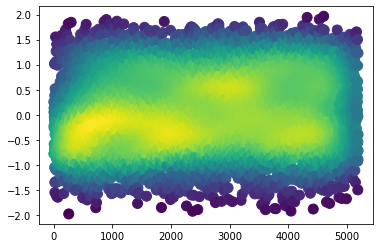

In [14]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = range(dfx["T3"].size)
y = dfx["T3"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
#plt.savefig("sp_3me_all.pdf

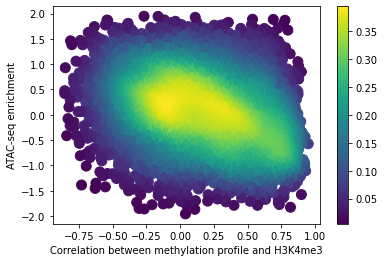

In [15]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = corrs
y = dfx["T4"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Fonts
#plt.rcParams['font.family'] = 'cmr10'  # o 'cmr12' o 'cmr17' para la fuente Computer Modern
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Correlation between methylation profile and H3K4me3")
plt.ylabel("ATAC-seq enrichment") 

cbar = fig.colorbar(scatter)

plt.savefig("corr_4me_all.svgz")

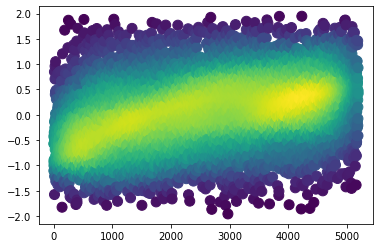

In [16]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = range(dfx["T4"].size)
y = dfx["T4"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
#plt.savefig("sp_4me_all.pdf")

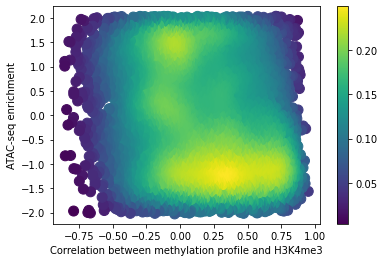

In [17]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = corrs
y = dfx["T5"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Fonts
#plt.rcParams['font.family'] = 'cmr10'  # o 'cmr12' o 'cmr17' para la fuente Computer Modern

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Correlation between methylation profile and H3K4me3")
plt.ylabel("ATAC-seq enrichment") 

cbar = fig.colorbar(scatter)

plt.savefig("corr_5me_all.svgz")

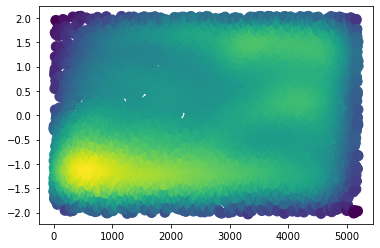

In [18]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = range(dfx["T5"].size)
y = dfx["T5"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
#plt.savefig("sp_5me_all.svg")

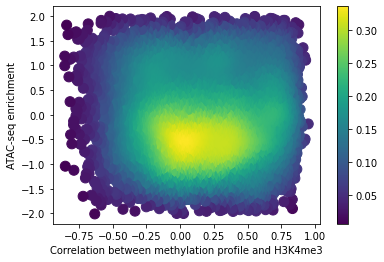

In [19]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = corrs
y = dfx["T6"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Fonts
#plt.rcParams['font.family'] = 'cmr10'  # o 'cmr12' o 'cmr17' para la fuente Computer Modern
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Correlation between methylation profile and H3K4me3")
plt.ylabel("ATAC-seq enrichment") 

cbar = fig.colorbar(scatter)
plt.savefig("corr_6me_all.svgz")

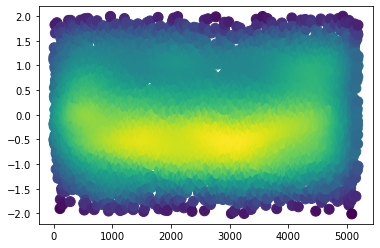

In [20]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = range(dfx["T6"].size)
y = dfx["T6"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
#plt.savefig("sp_6me_all.svg")

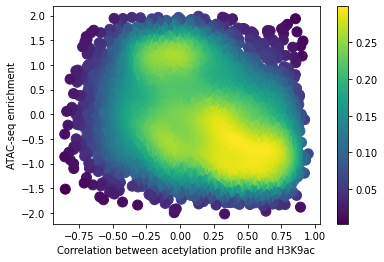

In [21]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = corrs
y = dfx["T1"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 

cbar = fig.colorbar(scatter)
plt.xlabel("Correlation between acetylation profile and H3K9ac")
plt.ylabel("ATAC-seq enrichment") 
plt.savefig("corr_1ac_all.svgz")

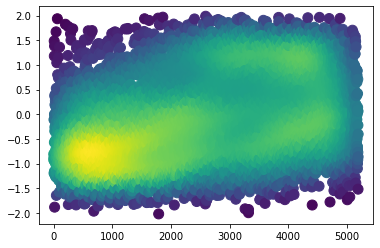

In [22]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = range(dfx["T1"].size)
y = dfx["T1"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
#plt.savefig("sp_1ac_all.svg")


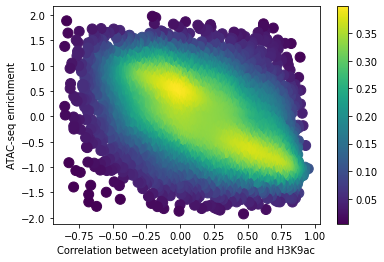

In [23]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = corrs
y = dfx["T2"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Correlation between acetylation profile and H3K9ac")
plt.ylabel("ATAC-seq enrichment") 

cbar = fig.colorbar(scatter)
plt.savefig("corr_2ac_all.svgz")

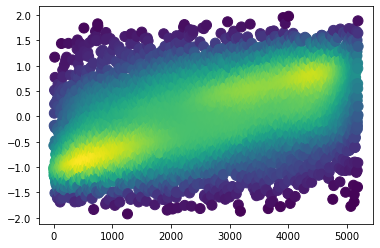

In [24]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate data
x = range(dfx["T2"].size)
y = dfx["T2"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
#plt.savefig("sp_2ac_all.svg")

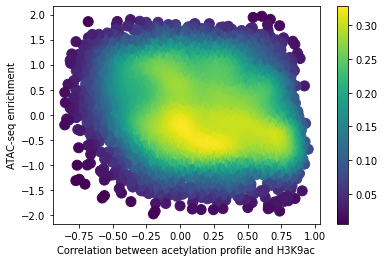

In [25]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = corrs
y = dfx["T3"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Correlation between acetylation profile and H3K9ac")
plt.ylabel("ATAC-seq enrichment") 

cbar = fig.colorbar(scatter)
plt.savefig("corr_3ac_all.svgz")

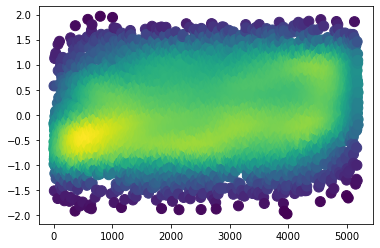

In [26]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = range(dfx["T3"].size)
y = dfx["T3"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
#plt.savefig("sp_3ac_all.svg")

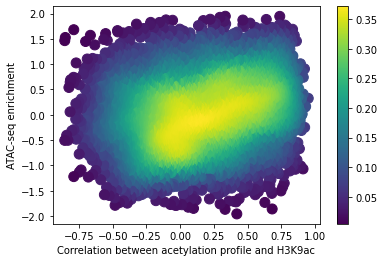

In [27]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = corrs
y = dfx["T4"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Correlation between acetylation profile and H3K9ac")
plt.ylabel("ATAC-seq enrichment") 

cbar = fig.colorbar(scatter)
plt.savefig("corr_4ac_all.svgz")

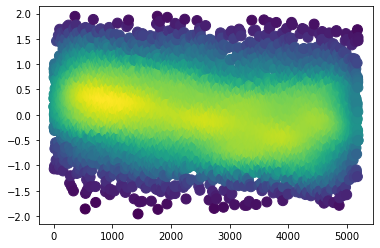

In [28]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = range(dfx["T4"].size)
y = dfx["T4"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
#plt.savefig("sp_4ac_all.svg")

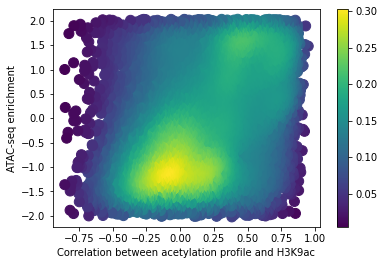

In [29]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = corrs
y = dfx["T5"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Correlation between acetylation profile and H3K9ac")
plt.ylabel("ATAC-seq enrichment") 

cbar = fig.colorbar(scatter)
plt.savefig("corr_5ac_all.svgz")

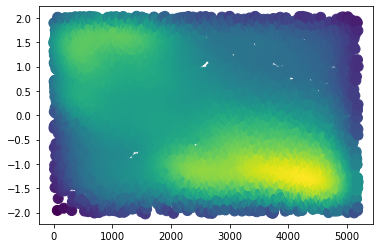

In [30]:
# Generate data
x = range(dfx["T5"].size)
y = dfx["T5"]
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
#plt.savefig("sp_5ac_all.svg")

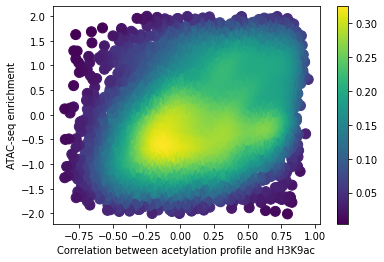

In [31]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = corrs
y = dfx["T6"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Correlation between acetylation profile and H3K9ac")
plt.ylabel("ATAC-seq enrichment")  

cbar = fig.colorbar(scatter)
plt.savefig("corr_6ac_all.svgz")

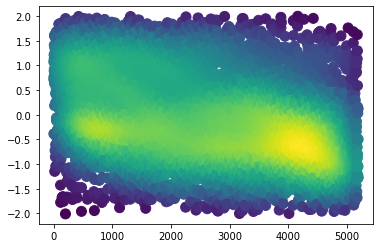

In [32]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate data
x = range(dfx["T6"].size)
y = dfx["T6"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
#plt.savefig("sp_6ac_all.svg")